In [1]:
import sys; sys.path.append("../../")
from DataPreprocessing.DataPreprocessing import *
from DataExploration.DataExploration import *
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Question:
    Can we predict Rating of a game based on features given: publisher, platform, critic score,... ?



## 1- Expectations: 
      The model should determine the game characteristics through critic score, developer,
      publisher and platform that best predict that Rating of a game.

## Read Data 

In [11]:
df = read_data(kind='dataset')
df = df.dropna()
df.head(10)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,594.0,Nintendo,E
11,Mario Kart DS,DS,2005.0,Racing,Nintendo,9.71,7.47,4.13,1.90,23.21,91.0,64.0,8.6,464.0,Nintendo,E
13,Wii Fit,Wii,2007.0,Sports,Nintendo,8.92,8.03,3.60,2.15,22.70,80.0,63.0,7.7,146.0,Nintendo,E
14,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,61.0,45.0,6.3,106.0,Good Science Studio,E
15,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,80.0,33.0,7.4,52.0,Nintendo,E


## EDA

### Rating Histogram

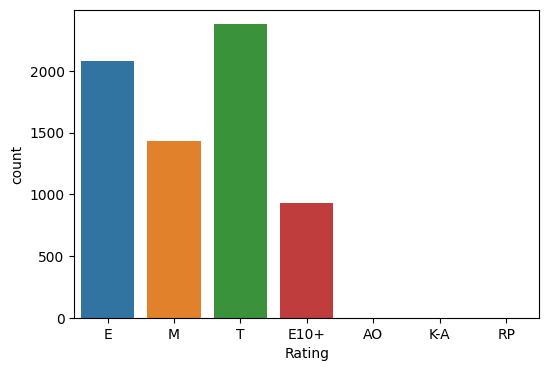

In [3]:
count_plot("Rating", df)

In [4]:
# drop ratings with less than 100 games
df = df.groupby('Rating').filter(lambda x: len(x) > 100)

### Rating & Critic Score
    

<Axes: xlabel='Rating', ylabel='Critic Score'>

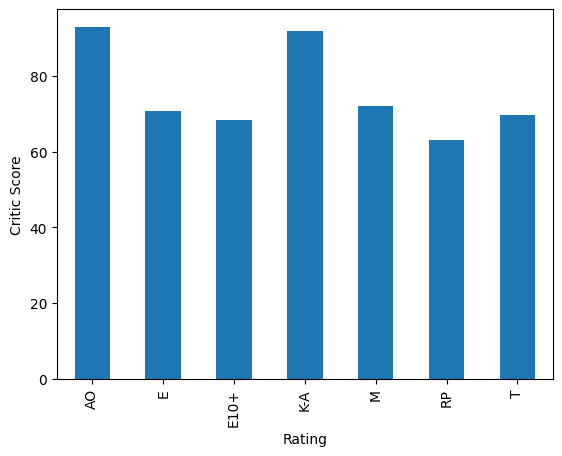

In [18]:
df.groupby('Rating')['Critic_Score'].mean().plot(kind='bar', ylabel='Critic Score')

### Rating & D Sales


<Axes: xlabel='Rating', ylabel='Global Sales (in millions)'>

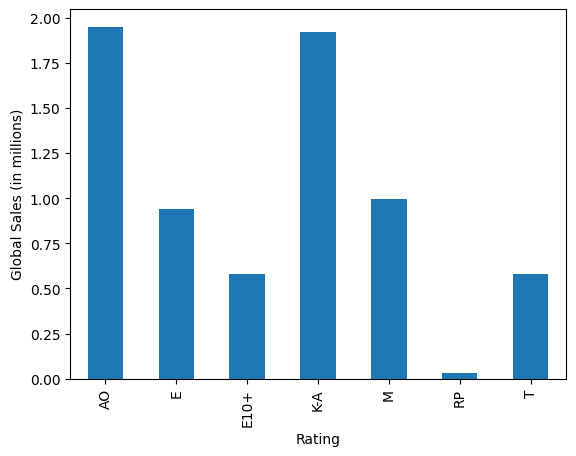

In [15]:
df.groupby('Rating')['Global_Sales'].mean().plot(kind='bar', ylabel='Global Sales (in millions)')

## Split Data

In [ ]:
# read the data
df_train=read_data(kind='train')
df_val = read_data(kind='val')
selected_cols=[ 'Platform', 'Genre', 'Publisher', 'Global_Sales', 'Critic_Score', 'Rating', 'Critic_Count']
df_train = df_train[selected_cols]
df_val = df_val[selected_cols]
df_train.head()

,Platform,Genre,Publisher,Global_Sales,Critic_Score,Rating,Critic_Count
0,X360,Shooter,Cave,0.06,NaN,NaN,NaN
1,WiiU,Action,Namco Bandai Games,0.06,66.0,T,11.0
2,DS,Role-Playing,Konami Digital Entertainment,0.23,82.0,E10+,39.0
3,PSP,Adventure,Yeti,0.01,NaN,NaN,NaN
4,X360,Action,Ubisoft,1.59,85.0,M,75.0


## Handle Missing values 
    - as all features used here are categorical, mode imputation is used 
      to handle missing values.


In [ ]:
# handle missing values using mode imputation
df_train =handle_missing_values(df_train, handling_method='mode_knn',neighbors=5)
df_val =handle_missing_values(df_val,handling_method='mode_knn',neighbors=5)

df_train.head()

Total Number of rows : 10031
Number of rows with missing values: 5226
Number of rows after handling missing values: 10031 and Number of missing values: 0
Total Number of rows : 3344
Number of rows with missing values: 1732
Number of rows after handling missing values: 3344 and Number of missing values: 0


,Platform,Genre,Publisher,Global_Sales,Critic_Score,Rating,Critic_Count
0,X360,Shooter,Cave,0.06,68.879268,E,26.315508
1,WiiU,Action,Namco Bandai Games,0.06,66.000000,T,11.000000
2,DS,Role-Playing,Konami Digital Entertainment,0.23,82.000000,E10+,39.000000
3,PSP,Adventure,Yeti,0.01,68.879268,E,26.315508
4,X360,Action,Ubisoft,1.59,85.000000,M,75.000000


### Drop rating values with number of rows less than 100

In [ ]:
df_train = df_train.groupby('Rating').filter(lambda x: len(x) > 400)
df_val = df_val.groupby('Rating').filter(lambda x: len(x) > 400)

In [ ]:
df_train = df_train[df_train['Rating'] != 'E10+']
df_val = df_val[df_val['Rating'] != 'E10+']

## prepare features and labels

In [ ]:
y_train = df_train['Rating']
X_train = df_train.drop('Rating', axis=1)
y_val = df_val['Rating']
X_val = df_val.drop('Rating', axis=1)
X_train.head()

,Platform,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count
0,X360,Shooter,Cave,0.06,68.879268,26.315508
1,WiiU,Action,Namco Bandai Games,0.06,66.000000,11.000000
3,PSP,Adventure,Yeti,0.01,68.879268,26.315508
4,X360,Action,Ubisoft,1.59,85.000000,75.000000
5,PS2,Adventure,Ubisoft,0.25,51.000000,32.000000


### Encode Categorical Features

In [ ]:
# encoding the categorical columns
X_train = encoding(X_train)
X_val = encoding(X_val)

# Models

### SVM

In [ ]:
# create the model
model = SVC(kernel='rbf', C=7)
# fit the model
model.fit(X_train, y_train)
# predict the model
y_pred = model.predict(X_val)
# get the accuracy score
print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')

Accuracy Score: 0.8004362050163577


In [ ]:
# create the model
model = SVC(kernel='linear')
# fit the model
model.fit(X_train, y_train)
# predict the model
y_pred = model.predict(X_val)
# get the accuracy score
print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')

Accuracy Score: 0.7724463831334061


### Random Forest

In [ ]:
# create the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# predict the model
y_pred = model.predict(X_val)
# get the accuracy score
print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')


Accuracy Score: 0.8033442384587423


### AdaBoost

In [ ]:
#try ada boost
# create the model
model = AdaBoostClassifier()
# fit the model
model.fit(X_train, y_train)
# predict the model
y_pred = model.predict(X_val)
# get the accuracy score
print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')


Accuracy Score: 0.7651762995274446


### Logistic Regression

In [ ]:
# create the model
model = LogisticRegression()
# fit the model
model.fit(X_train, y_train)
# predict the model
y_pred = model.predict(X_val)
# get the accuracy score
print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')


Accuracy Score: 0.7709923664122137


C:\Users\dell\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3- Comparing Expectations to collecting data and models:
    
    Data match expectations: Model succeed in predicting Rating of a game given
    sales, critic score, publisher, developer ,platform 
    
       
    